In [16]:
# Importacao das libraries
import pandas as pd
import functions as main
import numpy as np
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [17]:
csv = "df_lagged_weekly.csv"

opencsv = pd.read_csv(rf"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\{csv}", sep=",")
opencsv.set_index('Date', inplace=True)
opencsv.index = pd.to_datetime(opencsv.index)
opencsv = opencsv.asfreq(pd.infer_freq(opencsv.index))
opencsv = opencsv.astype(float)

In [18]:
df_model = opencsv.copy()

In [ ]:
df_model.isnull().sum()

## Seleção de Variáveis

Considerar técnicas como regressão lasso, ridge ou elastic net, que fazem seleção de variáveis automaticamente, pode ser útil se você suspeitar que nem todas as 20 variáveis são relevantes.

In [ ]:
df_model.columns

<div class="alert alert-block alert-info"><b>Hipoteses a testar</b>

H1: Ceteris paribus, Bitcoin é um ativo de especulação.

H2: Ceteris paribus, a performance de Bitcoin é influenciada por fatores macroeconómicos.

H3: Ceteris paribus, quanto mais liquidez há no mercado, maior é a apreciação de preço de Bitcoin.

H4: Ceteris paribus, os fatores endógenos de Bitcoin são os maiores explicadores da performance de Bitcoin.
</div>

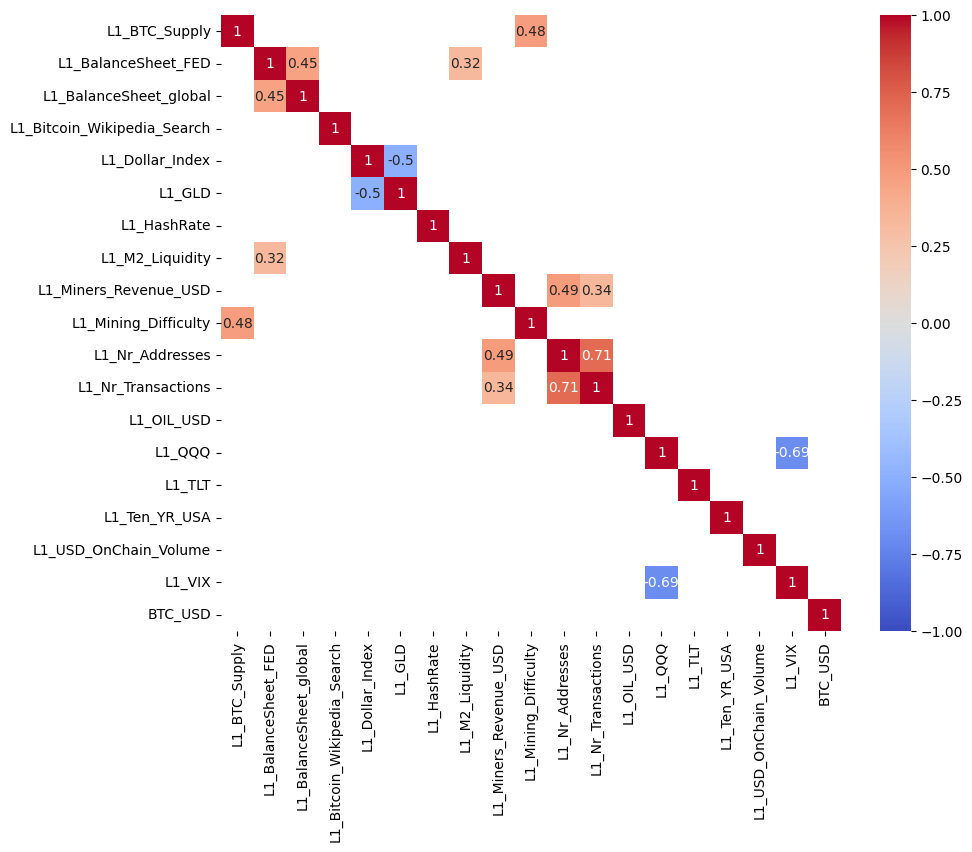

In [19]:
main.correlation_map(df=df_model, threshold=0.3)

## Regressao Linear Multipla

In [ ]:
# Yt = b0 + b1X1t + b2X2t + εt

# Modelos endogenos Bitcoin
# 'L1_BTC_Supply', 'L1_Bitcoin_Wikipedia_Search', 'L1_HashRate', 'L1_Miners_Revenue_USD', 
# 'L1_Mining_Difficulty', 'L1_Nr_Addresses', 'L1_Miners_Revenue_USD', 'L1_USD_OnChain_Volume'
model1a = [ 'L1_Bitcoin_Wikipedia_Search', 'L1_Miners_Revenue_USD', 'L1_Mining_Difficulty', 'L1_USD_OnChain_Volume'] 
model1b = [ 'L1_Nr_Transactions', 'L1_HashRate', 'L1_BTC_Supply', ]


# Modelos Macro Economicos
# 'L1_Ten_YR_USA', 'L1_BalanceSheet_global', 'L1_BalanceSheet_FED', 'L1_Dollar_Index', 
# 'L1_GLD', 'L1_M2_Liquidity', 'L1_OIL_USD', 'L1_QQQ', 'L1_TLT', 'L1_VIX'
model2a = [ 'L1_QQQ', 'L1_GLD', 'L1_M2_Liquidity', 'L1_TLT']
model2b = [ 'L1_VIX', 'L1_Dollar_Index', 'L1_BalanceSheet_global', 'L1_OIL_USD']


X = df_model[model2b]
y = df_model["BTC_USD"]

X = sm.add_constant(X) # Add a constant term to the predictors

model = sm.OLS(y, X)
# robust regression -> model.fit( cov_type = "HC3" ) 

results = model.fit( cov_type='HAC', cov_kwds={'maxlags':12,'use_correction':True} ) # Fit the OLS model 

#print(results.summary()) # Print the summary of the regression results

### Distribution of the residuals

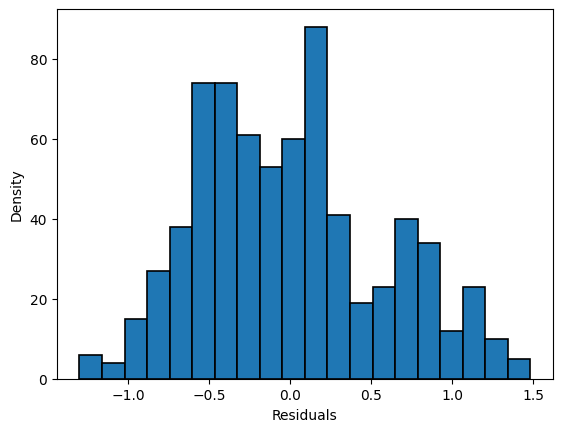

In [27]:
import matplotlib.pyplot as plt

residuals = results.resid

plt.figure(1)
plt.hist(residuals,20,edgecolor='black',linewidth=1.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

### Auto run Regressions

In [48]:
models_columns = ['model_1a', 'model_1b', 'model_2a', 'model_2b']

def run_models_stats(df, models_list, y, ciclo=None):
        if ciclo:
             pass
        count = 0
        for model_columns in models_list:
            X = df[model_columns]

            X = sm.add_constant(X)  # Add a constant term to the predictors

            model = sm.OLS(y, X)
            results = model.fit( cov_type='HAC', cov_kwds={'maxlags':12,'use_correction':True} )  # Fit the OLS model
            
            print("\n####################################################################################################### \n\n")
            print("\nModel:", models_columns[count]) # columns name
            #print("Variable:", results.params.index) # set as index
            print(f"\nCoeff: {results.params}") # coefficients
            print("\nP-Value:", results.pvalues) # p-values
            print("\nR-Squared:", results.rsquared_adj)
            print("No. Obs.:", results.nobs)
            print("Cond. no.:", results.condition_number)
            count += 1
            print("\n####################################################################################################### \n\n")


def run_models(df, models_list, y, i):
    f = open(f"V4_MLR_Results_Ciclo{i}.txt", "w")
    count = 0
    for model_columns in models_list:
        X = df[model_columns]

        X = sm.add_constant(X)  # Add a constant term to the predictors

        model = sm.OLS(y, X)
        results = model.fit( cov_type='HAC', cov_kwds={'maxlags':12,'use_correction':True} )  # Fit the OLS model
        
        f.write("\n####################################################################################################### \n\n")
        f.write(models_columns[count])
        f.write(" \n")
        f.write(f"{results.summary()}")
        count += 1
        f.write("\n####################################################################################################### \n\n")
    
    f.close()

In [49]:
models_list = [model1a, model1b, model2a, model2b]


for ciclo in range(1, 5):
    
    opencsv = pd.read_csv(rf"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\df_ciclo{ciclo}_weekly.csv", sep=",")
    y = opencsv["BTC_USD"]
    X = opencsv.drop(["BTC_USD"], axis = 1)
    run_models_stats(X, models_list, y, ciclo)


####################################################################################################### 



Model: model_1a

Coeff: const                         -4.223753
L1_Bitcoin_Wikipedia_Search    0.052733
L1_Miners_Revenue_USD          0.776743
L1_Mining_Difficulty           0.020263
L1_USD_OnChain_Volume          0.047373
dtype: float64

P-Value: const                          4.188866e-270
L1_Bitcoin_Wikipedia_Search     3.720093e-01
L1_Miners_Revenue_USD           6.063501e-58
L1_Mining_Difficulty            6.265887e-01
L1_USD_OnChain_Volume           1.468973e-01
dtype: float64

R-Squared: 0.9412505695267892
No. Obs.: 102.0
Cond. no.: 140.0789404915559

####################################################################################################### 



####################################################################################################### 



Model: model_1b

Coeff: const                 20.437567
L1_Nr_Transactions     0.618217
L1_HashRate          

In [ ]:
# list of all params 
dir(results)

# Testes

### Homocesdasticity

In [ ]:
import statsmodels.formula.api as smf

# https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/

### Normality of Residuals

Assumption: The residuals should be approximately normally distributed.

Test:
Q-Q Plot: Compare the quantiles of residuals to a normal distribution. If residuals are normal, the points will lie approximately on the 45-degree line.

Shapiro-Wilk Test or Kolmogorov-Smirnov Test: Statistical tests for normality of residuals.

Transformation: If residuals are not normally distributed, consider transforming the dependent variable or using robust regression methods.

### Independence of Errors


Assumption: The residuals (errors) should be independent of each other.

Test:

Durbin-Watson Test: Detects the presence of autocorrelation in residuals, especially in time series data.

Plot Residuals vs. Time: For time series data, plot residuals against time to detect patterns or autocorrelation.

Transformation:
Add Lagged Variables: For time series, include lagged values of the dependent variable as predictors.

### No Omitted Variable Bias

Assumption: All relevant independent variables are included in the model.

Test:

Ramsey RESET Test: Checks for omitted variables by testing for non-linearity in the model.

Remedies:

Include Relevant Variables: Ensure all theoretically important variables are included in the model.
Use Model Selection Criteria: Such as AIC or BIC to guide variable selection.

## Teste de Multicolinearidade


Como você tem muitas variáveis, é importante verificar a multicolinearidade, especialmente porque as variáveis acumuladas podem estar altamente correlacionadas entre si. Testes como o VIF (Variance Inflation Factor) podem ajudar a identificar problemas.

Multicollinearity describes the state where the independent variables used in a study exhibit a strong relationship with each other. This can pose a problem in many cases as you would normally want your independent variables to be… independent.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('BTC_USD ~ Nr_Transactions + L1_USD_OnChain_Volume + L1_BTC_Supply + L1_Mining_Difficulty', data=df_model, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif


#       Interpreting the VIF Values:
#       VIF < 5: Generally considered acceptable, indicating low to moderate multicollinearity.
#       VIF between 5 and 10: Indicates moderate to high multicollinearity, which may be problematic, but not necessarily requiring immediate removal.
#       VIF > 10: Strong multicollinearity, typically suggesting that the variable should be considered for removal or that further investigation is needed.